## Housing Valuation Model - Ames, Iowa
---

Goal: predict the value of the SalePrice variable.

## Navigator
1. [Data Cleaning](#p1) 
    - [Quantifying Ordinal & Categorising Nominal Features](#p2) 
    - [Filling missing data](#p3) 
    - [Removing Outliers](#p4) 
    
2. [Feature Engineering](#p5) 
3. [Exploratory Data Analysis (EDA)](#p6) 
4. [Additional Data Cleaning](#p7) 
5. [Train/Test Split](#p8) 
6. [Model Evaluation](#p9) 
7. [Shapley Plots](#p10)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv('datasets/train.csv')

## Basic Formatting

In [3]:
# Adjust display options
pd.options.display.max_rows = 555
pd.set_option('display.max_columns', None)

In [4]:
### Renaming columns to lower case
train.columns = train.columns.str.lower()

## Data Cleaning
<a id='p1'></a>

In [5]:
### Dropping initial unwanted columns
# No. of rows for reference - 2051
train.shape[0]

2051

**Dropping Columns**

In [6]:
# Preview dataset
train.head(2)

,id,pid,ms subclass,ms zoning,lot frontage,lot area,street,alley,lot shape,land contour,utilities,lot config,land slope,neighborhood,condition 1,condition 2,bldg type,house style,overall qual,overall cond,year built,year remod/add,roof style,roof matl,exterior 1st,exterior 2nd,mas vnr type,mas vnr area,exter qual,exter cond,foundation,bsmt qual,bsmt cond,bsmt exposure,bsmtfin type 1,bsmtfin sf 1,bsmtfin type 2,bsmtfin sf 2,bsmt unf sf,total bsmt sf,heating,heating qc,central air,electrical,1st flr sf,2nd flr sf,low qual fin sf,gr liv area,bsmt full bath,bsmt half bath,full bath,half bath,bedroom abvgr,kitchen abvgr,kitchen qual,totrms abvgrd,functional,fireplaces,fireplace qu,garage type,garage yr blt,garage finish,garage cars,garage area,garage qual,garage cond,paved drive,wood deck sf,open porch sf,enclosed porch,3ssn porch,screen porch,pool area,pool qc,fence,misc feature,misc val,mo sold,yr sold,sale type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000


In [7]:
# Drop IDs column
train = train.drop(columns=['id', 'pid'])

In [8]:
# Check for null values count
train.isnull().sum()

ms subclass           0
ms zoning             0
lot frontage        330
lot area              0
street                0
alley              1911
lot shape             0
land contour          0
utilities             0
lot config            0
land slope            0
neighborhood          0
condition 1           0
condition 2           0
bldg type             0
house style           0
overall qual          0
overall cond          0
year built            0
year remod/add        0
roof style            0
roof matl             0
exterior 1st          0
exterior 2nd          0
mas vnr type         22
mas vnr area         22
exter qual            0
exter cond            0
foundation            0
bsmt qual            55
bsmt cond            55
bsmt exposure        58
bsmtfin type 1       55
bsmtfin sf 1          1
bsmtfin type 2       56
bsmtfin sf 2          1
bsmt unf sf           1
total bsmt sf         1
heating               0
heating qc            0
central air           0
electrical      

In [9]:
# Drop unvaluable columns with large amounts of missing data
train = train.drop(columns=['alley', 'fireplace qu', 'pool qc', 'fence', 'misc feature', 'lot frontage'])

In [10]:
# With reference to dataset's data dictionary
# Drop columns with poor distribution

train['utilities'].value_counts()
# DROP: distribution: 2049, 1,  >>> not useful
train['condition 2'].value_counts()
# DROP: distribution too skewed
train['roof matl'].value_counts()
# DROP: distribution too skewed
train['heating'].value_counts()
# DROP: distribution too skewed
train['central air'].value_counts()
# Binary Column

Y    1910
N     141
Name: central air, dtype: int64

In [11]:
# Drop unvaluable columns with poor categorical distribution
train = train.drop(columns=[ 'utilities', 'condition 2', 'heating', 'roof matl'])

**Dropping Rows**

In [12]:
# Remove rows with few null values (1 or 2)
train.dropna(subset=['bsmtfin sf 1'], inplace=True)
train.dropna(subset=['bsmt unf sf'], inplace=True)
train.dropna(subset=['total bsmt sf'], inplace=True)
train.dropna(subset=['bsmt full bath'], inplace=True)
train.dropna(subset=['garage cars'], inplace=True)
train.dropna(subset=['garage area'], inplace=True)

In [13]:
# reset index to prevent any future formatting errors
train = train.reset_index(drop=True)

**Changing non-numeric data to quantifiable amounts**

In [14]:
### Checking datatypes
train.dtypes

ms subclass          int64
ms zoning           object
lot area             int64
street              object
lot shape           object
land contour        object
lot config          object
land slope          object
neighborhood        object
condition 1         object
bldg type           object
house style         object
overall qual         int64
overall cond         int64
year built           int64
year remod/add       int64
roof style          object
exterior 1st        object
exterior 2nd        object
mas vnr type        object
mas vnr area       float64
exter qual          object
exter cond          object
foundation          object
bsmt qual           object
bsmt cond           object
bsmt exposure       object
bsmtfin type 1      object
bsmtfin sf 1       float64
bsmtfin type 2      object
bsmtfin sf 2       float64
bsmt unf sf        float64
total bsmt sf      float64
heating qc          object
central air         object
electrical          object
1st flr sf           int64
2

**Perception of ratings cannot be evenly spaced, thus weights adjusted to saleprice if there is a presence of correlation**
<a id='p2'></a>

In [15]:
### Ranking ordinal column values - weight adjusted by comparing to saleprice if there are signs of corr
train['exter qual'] = train['exter qual'].map({'Ex':7.69, 'Gd':4.82, 'TA':3.07, 'Fa':2, 'Po':1, 'NA':0})
train['bsmt qual'] = train['bsmt qual'].map({'Ex':9.392, 'Gd':5.16, 'TA':3.075, 'Fa':2, 'Po':1, 'NA':0})
train['bsmt cond'] = train['bsmt cond'].map({'Ex':4.467, 'Gd':4.467, 'TA':3.167, 'Fa':1, 'Po':1, 'NA':0})
train['bsmt exposure'] = train['bsmt exposure'].map({'Gd':6.354, 'Av':3.086, 'Mn':2.242, 'No':1, 'NA':0})
train['garage finish'] = train['garage finish'].map({'Fin':4.303, 'RFn':3.136, 'Unf':1, 'NA':0})
train['garage qual'] = train['garage qual'].map({'Ex':4.897, 'Gd':4.897, 'TA':3.466, 'Fa':2.024, 'Po':1, 'NA':0})
train['paved drive'] = train['paved drive'].map({'Y':4.369, 'P':2.01, 'N':1})
train['electrical'] = train['electrical'].map({'Mix':1, 'FuseP':2.099, 'FuseF':3.4453, 'FuseA':4.7043, 'SBrkr':9.0514})
train['kitchen qual'] = train['kitchen qual'].map({'Po':1, 'Fa':2, 'TA':3.2722, 'Gd':5.6765, 'Ex':8.8363})

In [16]:
# low corr - weight unadjusted, ranked in even steps
train['bsmtfin type 1'] = train['bsmtfin type 1'].map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0})
train['garage cond'] = train['garage cond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0})
train['exter cond'] = train['exter cond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0})

**Converting columns with 2 non-numeric options**

In [17]:
### Converting binary column values
train['street'] = train['street'].map({'Pave':1, 'Grvl':0})
train['central air'] = train['central air'].map({'Y':1, 'N':0})

**Converting numeric columns to non-numeric columns due to nature of variable**

In [18]:
### Converting nominal columns to string
train['ms subclass'] = train['ms subclass'].map({20:'1S_1946', 30:'1S_1945', 40:'1S_attic', 45:'1.5S_unf', 50:'1.5S_fin', 60:'2S_1946', 70:'2S_1945', 75:'2.5S', 80:'Split_multi_lvl', 85:'Split_foyer', 90:'Duplex', 120:'1S_PUD', 150:'1.5S_PUD', 160:'2S_PUD', 180:'ML_PUD', 190:'2Fam_Conv'})
train['mo sold'] = train['ms subclass'].map({1:'Jan', 2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

**Determining appropriate methods to fill missing data**
<a id='p3'></a>

Variable has some reasonably high correlation with other variables, thus KNN used to predict based on those variables

In [19]:
### Filling in missing data
# bsmt qual - KNN used with highest correlated variables
knn_imp = KNNImputer()
train_mis = train[['bsmt qual', 'overall qual', 'year built', 'exter qual', 'year remod/add']]
knn_imp_income_missing = knn_imp.fit_transform(train_mis)
knn_imp_income_missing = pd.DataFrame(knn_imp_income_missing, columns = train_mis.columns)
train['bsmt qual'] = knn_imp_income_missing['bsmt qual']

# mas vnr area - KNN used with highest correlated variables
train_mis = train[['mas vnr area', '1st flr sf', 'bsmt qual', 'exter qual', 'total bsmt sf', 'overall qual']]
knn_imp_income_missing = knn_imp.fit_transform(train_mis)
knn_imp_income_missing = pd.DataFrame(knn_imp_income_missing, columns = train_mis.columns)
train['mas vnr area'] = knn_imp_income_missing['mas vnr area']

# bsmt cond - ordinal ranking reasonable thou heavy on 3
train.corr()['bsmt cond'].sort_values()
# highest corr 0.214, uneven distribution, mean values used to replace null values
train['bsmt cond'] = train['bsmt cond'].fillna(np.mean(train['bsmt cond']))

# bsmt exposure - KNN used with highest correlated variables
train_mis = train[['bsmt exposure', 'bsmt qual', 'bsmtfin sf 1', '1st flr sf', 'total bsmt sf', 'overall qual']]
knn_imp_income_missing = knn_imp.fit_transform(train_mis)
knn_imp_income_missing = pd.DataFrame(knn_imp_income_missing, columns = train_mis.columns)
train['bsmt exposure'] = knn_imp_income_missing['bsmt exposure']

# bsmtfin type 1 - KNN used with highest correlated variables
train_mis = train[['bsmtfin type 1', 'bsmtfin sf 1', 'bsmt full bath', 'bsmt unf sf']]
knn_imp_income_missing = knn_imp.fit_transform(train_mis)
knn_imp_income_missing = pd.DataFrame(knn_imp_income_missing, columns = train_mis.columns)
train['bsmtfin type 1'] = knn_imp_income_missing['bsmtfin type 1']

**Variable distribution is extremely unevenly distributed thus filled with mode**

In [20]:
### Filling in missing data - simple imputation (since distribution skewed)
# bsmtfin type 2 - filled with mode
train['bsmtfin type 2'] = train['bsmtfin type 2'].fillna('Unf')

# garage type - filled with mode
train['garage type'] = train['garage type'].fillna('Attchd')

# garage qual - filled with mode
train['garage qual'] = train['garage qual'].fillna(3.466)

# garage cond - filled with mode
train['garage cond'] = train['garage cond'].fillna(3)

# land slope - filled with mode
train['land slope'] = train['land slope'].fillna('Gtl')

**Very strong correlation with a specific variable so filled accordingly**

In [21]:
# garage yr built - filled with 'yr built'
train['garage yr blt'] = train['garage yr blt'].fillna(train['year built'])

**Value counts no clear distributions thus mean is used**

In [22]:
train['garage finish'].value_counts()

1.000    847
3.136    579
4.303    509
Name: garage finish, dtype: int64

In [23]:
# garage finish - filled with mean 
train['garage finish'] = train['garage finish'].fillna(np.mean(train['garage finish']))

**Removing outliers** \
Features with a significant difference in max & 75% identified and explored for outliers. \
No. of outliers dropped dependent on position & impact on model score.
<a id='p4'></a>

train.describe()

In [24]:
train.describe()

,lot area,street,overall qual,overall cond,year built,year remod/add,mas vnr area,exter qual,exter cond,bsmt qual,bsmt cond,bsmt exposure,bsmtfin type 1,bsmtfin sf 1,bsmtfin sf 2,bsmt unf sf,total bsmt sf,central air,electrical,1st flr sf,2nd flr sf,low qual fin sf,gr liv area,bsmt full bath,bsmt half bath,full bath,half bath,bedroom abvgr,kitchen abvgr,kitchen qual,totrms abvgrd,fireplaces,garage yr blt,garage finish,garage cars,garage area,garage qual,garage cond,paved drive,wood deck sf,open porch sf,enclosed porch,3ssn porch,screen porch,pool area,misc val,yr sold,saleprice
count,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000
mean,10049.675293,0.996582,6.114258,5.560547,1971.751465,1984.193848,100.057324,3.834722,3.085938,4.499755,3.150915,1.947053,3.629492,442.464844,48.005859,568.130859,1058.601562,0.931152,8.632856,1163.431152,329.378906,5.520996,1498.331055,0.427734,0.063477,1.576660,0.371094,2.842773,1.042969,4.595580,6.435059,0.590820,1976.757812,2.507995,1.776855,473.692871,3.420529,2.977051,4.075680,93.886230,47.444824,22.501465,2.595215,16.535645,2.401367,51.649902,2007.775879,181484.252441
std,6697.167566,0.058378,1.426126,1.104349,30.174112,21.033925,174.846666,1.147534,0.373051,1.856599,0.486092,1.645629,2.052622,461.319862,165.074675,444.958855,448.999749,0.253257,1.357302,392.294626,425.680677,51.105842,497.948344,0.522715,0.251763,0.548553,0.501083,0.825631,0.209937,1.681336,1.557145,0.637957,27.071436,1.361501,0.764702,215.972053,0.328903,0.218716,0.925854,128.597923,66.393358,59.738209,25.247901,57.412746,37.810135,573.810601,1.312844,79248.657891
min,1300.000000,0.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,1872.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2006.000000,12789.000000
25%,7500.000000,1.000000,5.000000,5.000000,1954.000000,1964.750000,0.000000,3.070000,3.000000,3.075000,3.167000,1.000000,1.000000,0.000000,0.000000,220.000000,793.000000,1.000000,9.051400,879.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,3.272200,5.000000,0.000000,1959.000000,1.000000,1.000000,319.000000,3.466000,3.000000,4.369000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2007.000000,129837.500000
50%,9432.000000,1.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,3.070000,3.000000,5.160000,3.167000,1.000000,4.000000,368.000000,0.000000,475.000000,995.500000,1.000000,9.051400,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,3.272200,6.000000,1.000000,1978.000000,3.136000,2.000000,480.000000,3.466000,3.000000,4.369000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2008.000000,162500.000000
75%,11512.750000,1.000000,7.000000,6.000000,2001.000000,2004.000000,160.250000,4.820000,3.000000,5.160000,3.167000,2.242000,6.000000,734.000000,0.000000,811.000000,1319.000000,1.000000,9.051400,1405.000000,691.750000,0.000000,1728.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,5.676500,7.000000,1.000000,2002.000000,3.136000,2.000000,576.000000,3.466000,3.000000,4.369000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000,214000.000000


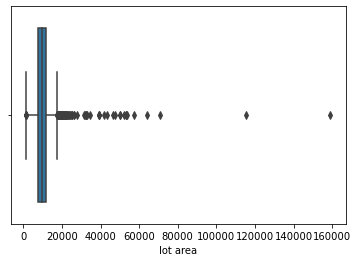

In [25]:
# variable 'lot area'
train.sort_values(by=['lot area'], ascending = False)
sns.boxplot(x=train['lot area'])
train = train.drop(train.index[[471,693]])

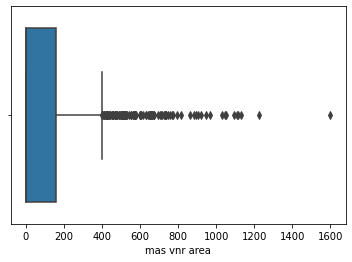

In [26]:
# variable 'mas vnr area'
train.sort_values(by=['mas vnr area'], ascending = False)
sns.boxplot(x=train['mas vnr area'])
train = train.drop(1407)

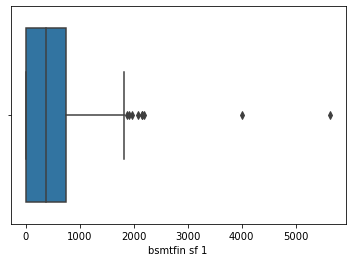

In [27]:
# variable 'bsmtfin sf 1'
train.sort_values(by=['bsmtfin sf 1'], ascending = False)
sns.boxplot(x=train['bsmtfin sf 1'])
train = train.drop([1669, 684, 622, 1157])

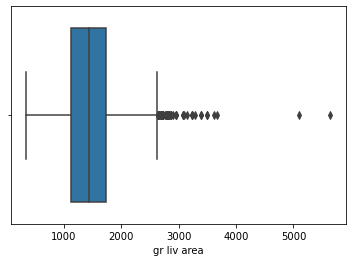

In [28]:
### Outliers removed after .describe(), sort_values() and boxplot if necessary
# variable 'gr liv area'
train.sort_values(by=['gr liv area'], ascending = False)
sns.boxplot(x=train['gr liv area'])
train = train.drop([959,1882])

**

In [29]:
# reset index to prevent any future formatting errors
train = train.reset_index(drop=True)

<a id='p5'></a>
## Feature Engineering
New interactions terms created based on logical deductions & tested against saleprice to test its relevance.

In [30]:
### Feature Engineering - new variables with high corr
train['house size'] = train['1st flr sf'] + train['garage area'] + train['open porch sf'] + train['wood deck sf'] + train['enclosed porch'] + train['screen porch'] + train['3ssn porch']
display(train['house size'].corr(train['saleprice']))

train['porch sf'] = train['open porch sf'] + train['enclosed porch'] + train['3ssn porch'] + train['screen porch'] + train['wood deck sf']
display(train['porch sf'].corr(train['saleprice']))

train['total bath'] = train['full bath']*3 + train['half bath'] + train['bsmt full bath']*2 + train['bsmt half bath']
train['total bath'].corr(train['saleprice'])


0.7609872130388552

0.41258493653670997

0.6465552698247691

**Creating dummies for categorical variables**

In [31]:
### Creating dummies for nominal column values
train_dum = pd.get_dummies(train, columns=['mo sold','mas vnr type','ms zoning', 'ms subclass',
                                           'lot shape', 'land contour', 'lot config', 'neighborhood', 
                                           'condition 1', 'bldg type', 'house style', 'roof style', 
                                           'exterior 1st', 'exterior 2nd', 'foundation','heating qc', 
                                           'functional', 'garage type', 'sale type'],  drop_first=True)
# Preserve dataframe for test
train_clean = train_dum

**Remove noise variables (corr close to 0) if necessary. Uncomment if so.**

In [32]:
# # Function to remove features with corr close to 0 if necessary
# for i in train_dum:
#     if train_dum[i].dtypes != 'object':
#         if train_dum[i].corr(train_dum['saleprice']) <= 0.04 and train_dum[i].corr(train_dum['saleprice']) >= -0.04:
#             train_clean = train_clean.drop(columns=[i])

<a id='p6'></a>
## Exploratory Data Analysis
Rough overview to check for potential multicollinearity

<AxesSubplot:>

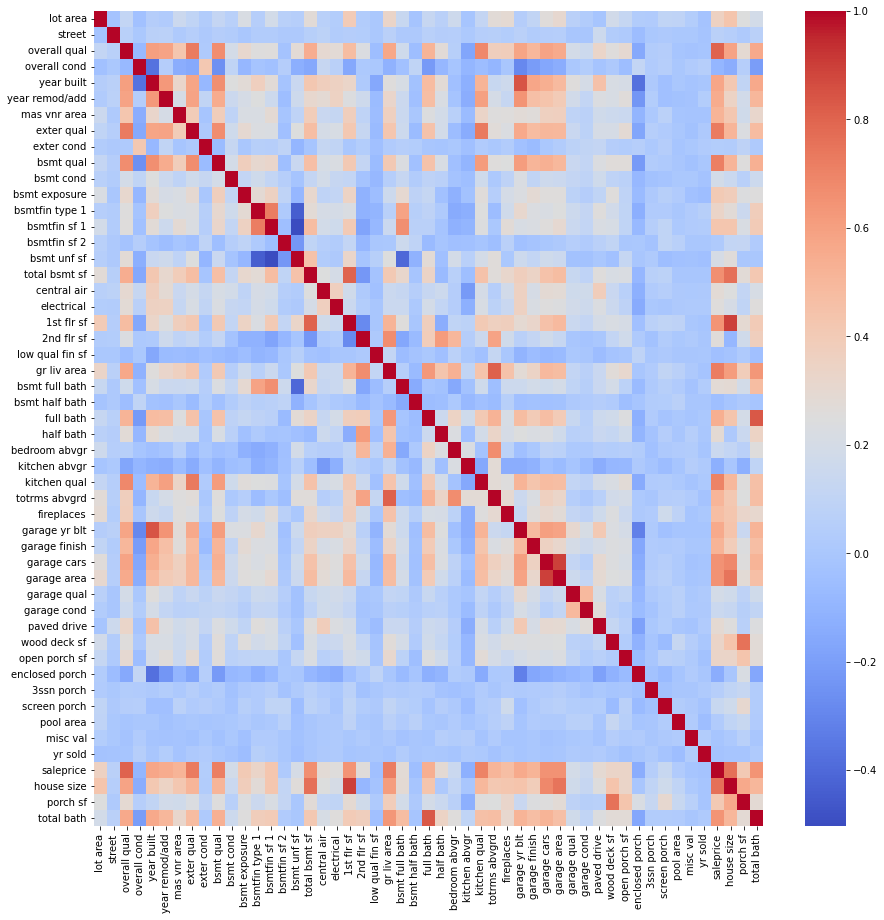

In [33]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), cmap='coolwarm')

**Top 10 variables correlated to saleprice:**

In [34]:
train.corr()['saleprice'].sort_values(ascending=False).head(11)

saleprice        1.000000
overall qual     0.805048
house size       0.760987
exter qual       0.725882
gr liv area      0.720772
bsmt qual        0.712720
kitchen qual     0.705973
total bsmt sf    0.659563
garage area      0.652662
garage cars      0.649265
total bath       0.646555
Name: saleprice, dtype: float64

#### Visualisation of historical data size of top 2 variables
Variable: Overall quality aka overall qual

In [35]:
# Groupby 'overall qual' and get the mean 'saleprice' and save it into a new dataframe 'overall_quality'
overall_quality = train_dum.groupby('overall qual')['saleprice'].agg(['mean'])

In [36]:
# Rename 'mean' to 'saleprice_mean'
overall_quality.rename(columns={'mean': 'saleprice_mean'}, inplace = True)

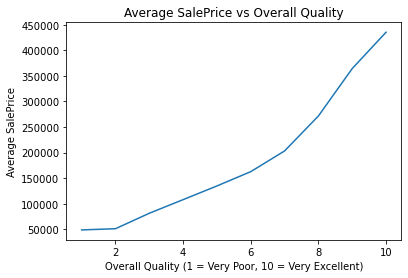

In [37]:
# Plot a line graph of Mean Saleprice vs Overall Quality
overall_quality['saleprice_mean'].plot();
plt.xlabel('Overall Quality (1 = Very Poor, 10 = Very Excellent)');
plt.ylabel('Average SalePrice');                              
plt.title('Average SalePrice vs Overall Quality');  

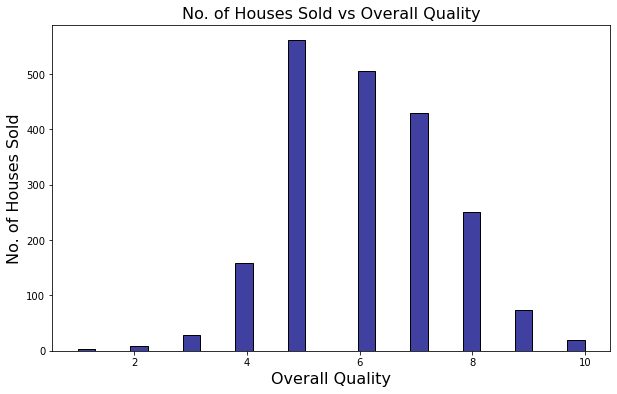

In [38]:
# Histogram of No. of Houses Sold vs Overall Quality
fig, histo_overall_qual = plt.subplots(figsize=(10,6))
color = 'navy'
histo_overall_qual.set_title('No. of Houses Sold vs Overall Quality', fontsize=16)
histo_overall_qual.set_xlabel('Overall Quality', fontsize=16)
histo_overall_qual.set_ylabel('No. of Houses Sold', fontsize=16)
histo_overall_qual = sns.histplot(x='overall qual', data = train_dum, color=color)
# plt.xlim(0,10)
plt.show()

Variable: House size

In [39]:
# Groupby 'house size' and get the mean 'saleprice' and save it into a new dataframe 'housesize'
housesize = train_dum.groupby('house size')['saleprice'].agg(['mean'])

In [40]:
# Rename 'mean' to 'saleprice_mean'
housesize.rename(columns={'mean': 'saleprice_mean'}, inplace = True)

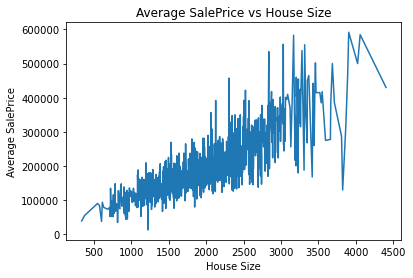

In [41]:
# Plot a line graph of Mean Saleprice vs Overall Quality
housesize['saleprice_mean'].plot();
plt.xlabel('House Size');
plt.ylabel('Average SalePrice');                              
plt.title('Average SalePrice vs House Size');  

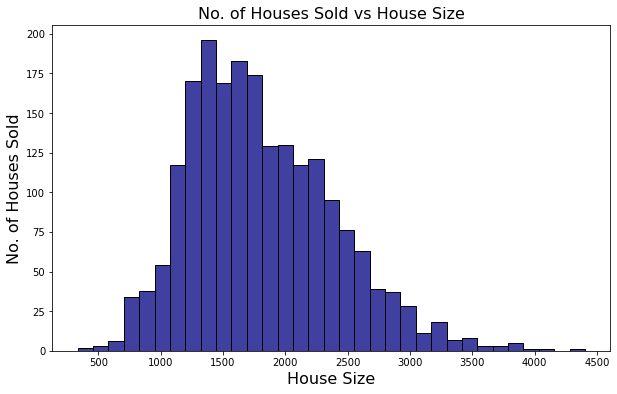

In [42]:
# For 2nd highest variable house size
fig, histo_overall_qual = plt.subplots(figsize=(10,6))
color = 'navy'
histo_overall_qual.set_title('No. of Houses Sold vs House Size', fontsize=16)
histo_overall_qual.set_xlabel('House Size', fontsize=16)
histo_overall_qual.set_ylabel('No. of Houses Sold', fontsize=16)
histo_overall_qual = sns.histplot(x='house size', data = train_dum, color=color)
plt.show()

<a id='p7'></a>
**Dropping additional columns due to multicollinearity**

In [43]:
### More variables dropped thru comparison with model scores
train = train.drop(columns=['land slope', 'bsmtfin type 2', 'totrms abvgrd', 'total bsmt sf'])

<a id='p8'></a>
## Train/Test Split

In [44]:
# Train/Test Split
features = [col for col in train_clean._get_numeric_data().columns if col != 'saleprice']
X = train_clean[features]
y = train_clean['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Linear Regression**

In [45]:
# Instantiating LinReg & LinReg R2
# Done before scaling did not have its intended impact on the near full list of variables since it resulted in the negative r2 score
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_scores = cross_val_score(lr, X_train, y_train, cv=10)
display(lr_scores.mean())

lr_scores = cross_val_score(lr, X_test, y_test, cv=10)
display(lr_scores.mean())

0.8986372745140191

0.8848635105919074

In [46]:
# Fitting to training data
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

**Lasso Regression**

In [47]:
# Testing out 200 different alpha values on default 5-folds of data set and adopt the best performing alpha
lasso = LassoCV(n_alphas=200)
# Cross val score fitted to train data for Lasso CV
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)
lasso_scores.mean()

# Lasso R2 on train & test
lasso.fit(X_train, y_train)
display(lasso.score(X_train, y_train))
display(lasso.score(X_test, y_test))

0.9267702402416365

0.9321744267064982

**Ridge Regression**

In [48]:
# Test out 100 different evenly spaced alpha values between 0.1 and 10 on default 5-folds of data set and adopt the best performing alpha
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))
# Cross val score fitted to train data for Ridge CV
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)
ridge_scores.mean()

ridge.fit(X_train, y_train)
display(ridge.score(X_train, y_train))
display(ridge.score(X_test, y_test))

0.9315434549701037

0.9288604283596371

**Models taken to be optimised as LassoCV and RidgeCV were used**

<a id='p9'></a>
## Model Evaluation

|Model|Train Results|Test Results
|:--|:-:|:-:|
|Linear Regression|0.89864|0.88486|
|Lasso Regression|0.92677|**0.93217**|
|Ridge Regression|**0.93154**|0.92886|


Lasso highest test scores thus utilised

**Lasso Model coefficients**

<AxesSubplot:>

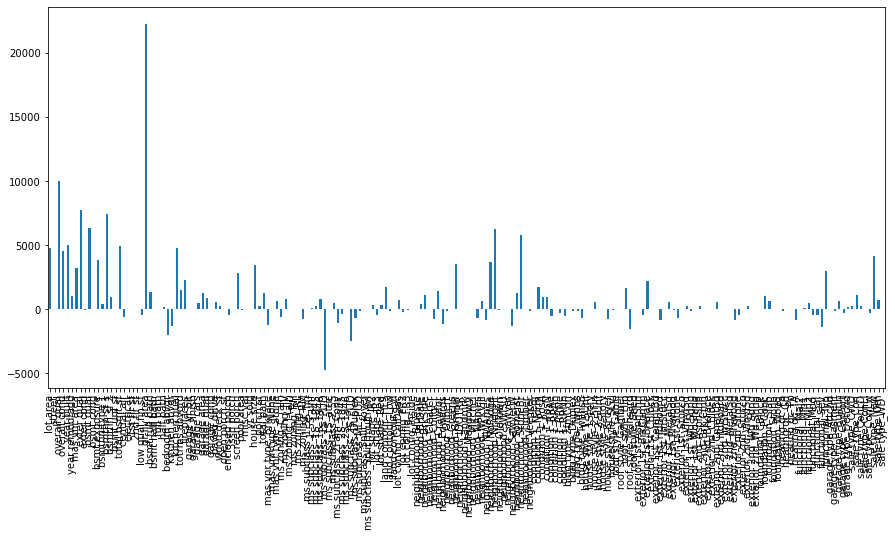

In [49]:
pd.Series(lasso.coef_, index=features).plot.bar(figsize=(15, 7))

Displayed in a dataframe to see actual values

In [50]:
# Create df for storing coefficients and their corresponding variable names
coefficient_df = pd.DataFrame()

# Storing all the column names of predictors
coefficient_df['Column_Name'] = features

# Store coefficients of predictors
coefficient_df['Coefficient_Value'] = pd.Series(lasso.fit(X_train, y_train).coef_)

# Preview variables' coefficient values
# The higher the values, the stronger the variables
print(coefficient_df)

                     Column_Name  Coefficient_Value
0                       lot area        4806.412968
1                         street           0.000000
2                   overall qual        9990.559230
3                   overall cond        4568.684303
4                     year built        5031.959851
5                 year remod/add        1027.203366
6                   mas vnr area        3233.248226
7                     exter qual        7778.994240
8                     exter cond         -35.332578
9                      bsmt qual        6374.190017
10                     bsmt cond           0.000000
11                 bsmt exposure        3853.578160
12                bsmtfin type 1         430.913861
13                  bsmtfin sf 1        7440.699425
14                  bsmtfin sf 2         990.998380
15                   bsmt unf sf          -0.000000
16                 total bsmt sf        4916.822162
17                   central air        -586.363795
18          

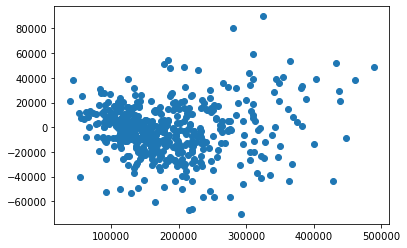

In [51]:
pred = lasso.predict(X_test)
residuals = y_test - pred
plt.scatter(pred, residuals)

<a id='p10'></a>
**SHAPLEY plots to understand which features impact our model the most**

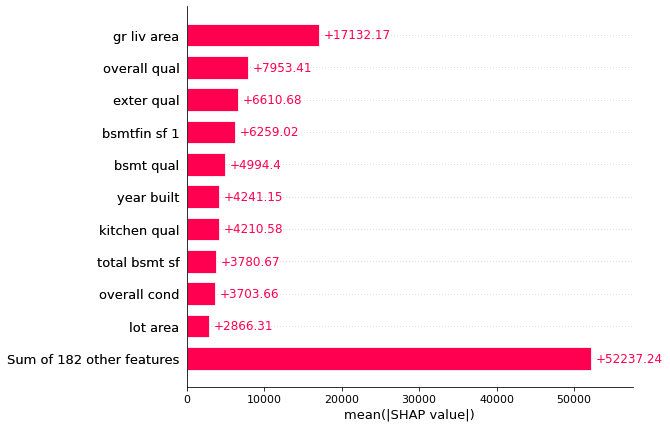

In [52]:
# Shapley Values
explainer = shap.explainers.Linear(lasso, X_train)
shap_values = explainer(X_train)

# Add back the feature names removed by the StandardScaler
for i,c in enumerate(X.columns):
    shap_values.feature_names[i] = c

# Visualise variable importance for top 10 features
# Set max_display to 11 so that 
shap.plots.bar(shap_values, max_display=11)

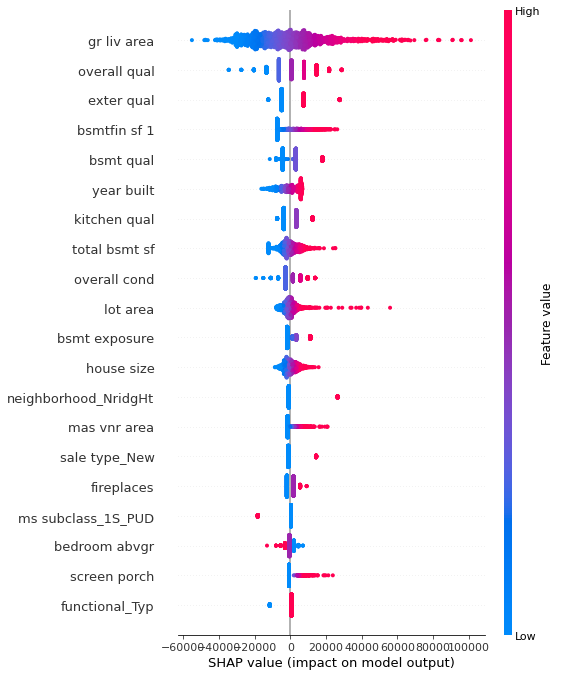

In [53]:
# Visualise values that limit our model's performance
explainer = shap.explainers.Linear(lasso, X_train)
lasso_shap_values = explainer(X_train)

# Add back the feature names removed by the StandardScaler
for i,c in enumerate(X.columns):
    lasso_shap_values.feature_names[i] = c

shap.summary_plot(lasso_shap_values, X_train)

# Below Portion are repeated steps used to export a csv for a Kaggle Challenge (Discontinued temporarily)

In [54]:
test_set = pd.read_csv('datasets/test.csv')

In [55]:
# Same data cleaning steps applied
test_set.columns = test_set.columns.str.lower()

# Saving unedited set
test_raw = test_set

test_set = test_set.drop(columns=['id', 'pid'])
test_set = test_set.drop(columns=['alley', 'fireplace qu', 'pool qc', 'fence', 'misc feature', 'lot frontage'])
test_set = test_set.drop(columns=[ 'utilities', 'condition 2', 'heating', 'roof matl'])

# test_set.dropna(subset=['bsmtfin sf 1'], inplace=True)
# test_set.dropna(subset=['bsmt unf sf'], inplace=True)
# test_set.dropna(subset=['total bsmt sf'], inplace=True)
# test_set.dropna(subset=['bsmt full bath'], inplace=True)
# test_set.dropna(subset=['garage cars'], inplace=True)
# test_set.dropna(subset=['garage area'], inplace=True)

In [56]:
test_set['exter qual'] = test_set['exter qual'].map({'Ex':7.69, 'Gd':4.82, 'TA':3.07, 'Fa':2, 'Po':1, 'NA':0})
test_set['bsmt qual'] = test_set['bsmt qual'].map({'Ex':9.392, 'Gd':5.16, 'TA':3.075, 'Fa':2, 'Po':1, 'NA':0})
test_set['bsmt cond'] = test_set['bsmt cond'].map({'Ex':4.467, 'Gd':4.467, 'TA':3.167, 'Fa':1, 'Po':1, 'NA':0})
test_set['bsmt exposure'] = test_set['bsmt exposure'].map({'Gd':6.354, 'Av':3.086, 'Mn':2.242, 'No':1, 'NA':0})
test_set['garage finish'] = test_set['garage finish'].map({'Fin':4.303, 'RFn':3.136, 'Unf':1, 'NA':0})
test_set['garage qual'] = test_set['garage qual'].map({'Ex':4.897, 'Gd':4.897, 'TA':3.466, 'Fa':2.024, 'Po':1, 'NA':0})
test_set['paved drive'] = test_set['paved drive'].map({'Y':4.369, 'P':2.01, 'N':1})
test_set['electrical'] = test_set['electrical'].map({'Mix':1, 'FuseP':2.099, 'FuseF':3.4453, 'FuseA':4.7043, 'SBrkr':9.0514})
test_set['kitchen qual'] = test_set['kitchen qual'].map({'Po':1, 'Fa':2, 'TA':3.2722, 'Gd':5.6765, 'Ex':8.8363})
test_set['bsmtfin type 1'] = test_set['bsmtfin type 1'].map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0})
test_set['garage cond'] = test_set['garage cond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0})
test_set['exter cond'] = test_set['exter cond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0})
test_set['street'] = test_set['street'].map({'Pave':1, 'Grvl':0})
test_set['central air'] = test_set['central air'].map({'Y':1, 'N':0})
test_set['ms subclass'] = test_set['ms subclass'].map({20:'1S_1946', 30:'1S_1945', 40:'1S_attic', 45:'1.5S_unf', 50:'1.5S_fin', 60:'2S_1946', 70:'2S_1945', 75:'2.5S', 80:'Split_multi_lvl', 85:'Split_foyer', 90:'Duplex', 120:'1S_PUD', 150:'1.5S_PUD', 160:'2S_PUD', 180:'ML_PUD', 190:'2Fam_Conv'})
test_set['mo sold'] = test_set['ms subclass'].map({1:'Jan', 2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})


In [57]:
# bsmt qual - KNN used with highest correlated variables
knn_imp = KNNImputer()
test_set_mis = test_set[['bsmt qual', 'overall qual', 'year built', 'exter qual', 'year remod/add']]
knn_imp_income_missing = knn_imp.fit_transform(test_set_mis)
knn_imp_income_missing = pd.DataFrame(knn_imp_income_missing, columns = test_set_mis.columns)
test_set['bsmt qual'] = knn_imp_income_missing['bsmt qual']

# mas vnr area - KNN used with highest correlated variables
test_set_mis = test_set[['mas vnr area', '1st flr sf', 'bsmt qual', 'exter qual', 'total bsmt sf', 'overall qual']]
knn_imp_income_missing = knn_imp.fit_transform(test_set_mis)
knn_imp_income_missing = pd.DataFrame(knn_imp_income_missing, columns = test_set_mis.columns)
test_set['mas vnr area'] = knn_imp_income_missing['mas vnr area']

# bsmt cond - ordinal ranking reasonable thou heavy on 3
test_set.corr()['bsmt cond'].sort_values()
# highest corr 0.214, uneven distribution, mean values used to replace null values
test_set['bsmt cond'] = test_set['bsmt cond'].fillna(np.mean(test_set['bsmt cond']))

# bsmt exposure - KNN used with highest correlated variables
test_set_mis = test_set[['bsmt exposure', 'bsmt qual', 'bsmtfin sf 1', '1st flr sf', 'total bsmt sf', 'overall qual']]
knn_imp_income_missing = knn_imp.fit_transform(test_set_mis)
knn_imp_income_missing = pd.DataFrame(knn_imp_income_missing, columns = test_set_mis.columns)
test_set['bsmt exposure'] = knn_imp_income_missing['bsmt exposure']

# bsmtfin type 1 - KNN used with highest correlated variables
test_set_mis = test_set[['bsmtfin type 1', 'bsmtfin sf 1', 'bsmt full bath', 'bsmt unf sf']]
knn_imp_income_missing = knn_imp.fit_transform(test_set_mis)
knn_imp_income_missing = pd.DataFrame(knn_imp_income_missing, columns = test_set_mis.columns)
test_set['bsmtfin type 1'] = knn_imp_income_missing['bsmtfin type 1']

In [58]:
# bsmtfin type 2 - filled with mode
test_set['bsmtfin type 2'] = test_set['bsmtfin type 2'].fillna('Unf')
# garage type - filled with mode
test_set['garage type'] = test_set['garage type'].fillna('Attchd')
# garage yr built - filled with 'yr built'
test_set['garage yr blt'] = test_set['garage yr blt'].fillna(test_set['year built'])
# garage finish - filled with mean 
test_set['garage finish'] = test_set['garage finish'].fillna(np.mean(test_set['garage finish']))
# garage qual - filled with mode
test_set['garage qual'] = test_set['garage qual'].fillna(3.466)
# garage cond - filled with mode
test_set['garage cond'] = test_set['garage cond'].fillna(3)
# land slope - filled with mode
test_set['land slope'] = test_set['land slope'].fillna('Gtl')

In [59]:
test_set['house size'] = test_set['1st flr sf'] + test_set['garage area'] + test_set['open porch sf'] + test_set['wood deck sf'] + test_set['enclosed porch'] + test_set['screen porch'] + test_set['3ssn porch']
test_set['porch sf'] = test_set['open porch sf'] + test_set['enclosed porch'] + test_set['3ssn porch'] + test_set['screen porch'] + test_set['wood deck sf']
test_set['total bath'] = test_set['full bath']*3 + test_set['half bath'] + test_set['bsmt full bath']*2 + test_set['bsmt half bath']

test_set = test_set.drop(columns=['land slope', 'bsmtfin type 2', 'totrms abvgrd', 'total bsmt sf'])
test_set = test_set.drop(columns=['mo sold'])

In [60]:
# Display null value & filled accordingly
test_set[test_set['mas vnr type'].isnull()].head()
train.groupby(['mas vnr type'])[['saleprice']].describe()
test_set['mas vnr type'] = test_set['mas vnr type'].fillna('None')

test_set[test_set['electrical'].isnull()].head()
test_set['electrical'].value_counts()
test_set['electrical'] = test_set['electrical'].fillna(9.0514)

# # Filling mo sold with KNN
# test_set['mo sold'] = test_set['mo sold'].fillna()

In [61]:
test_set_dum = pd.get_dummies(test_set, columns=['mas vnr type','ms zoning', 'ms subclass','lot shape', 'land contour', 'lot config', 'neighborhood', 'condition 1', 'bldg type', 'house style', 'roof style', 'exterior 1st', 'exterior 2nd', 'foundation','heating qc', 'functional', 'garage type', 'sale type'],  drop_first=True)


In [62]:
# Matching columns to regression model
temp = train_dum
temp = temp.drop(columns=['saleprice'])
test_set_dum = test_set_dum.reindex(temp.columns, fill_value=0, axis=1)   

In [63]:
# Setting the transforming the test_data variables
test_clean = ss.transform(test_set_dum)

# Predict sale prices using Regression
lasso_pred = lasso.predict(test_clean)
test_set['saleprice'] = lasso_pred

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- bsmtfin type 2
- land slope
Feature names must be in the same order as they were in fit.



ValueError: X has 194 features, but StandardScaler is expecting 192 features as input.

In [ ]:
# Sanity check - pred comparison to train data
display(train['saleprice'].describe())
test_set['saleprice'].describe()

In [ ]:
# Prep for export
test_export = test_raw[['id']]
test_export['saleprice'] = test_set['saleprice']
test_export.to_csv("datasets/test_results.csv")